In [0]:
import pandas as pd
import numpy as np

import spacy
import torchtext
from torchtext import data
from torchtext import vocab

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook, tnrange

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 1. Process dataset using torchtext

Dataset is cleaned and pre-processed using same techniques used for PeerRead dataset. 

** Load the dataset of 100k samples **

In [0]:
# # Load 100k Yelp reviews having 20k reviews for each of 5 classes
main_df = pd.read_csv('./yelp_df_100k.csv', error_bad_lines=False) # error_bad_lines=False, drop bad_lines

In [6]:
# # Check for empty text or stars
np.where(main_df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [7]:
main_df['text'] = main_df['text'].str.findall('\w{3,}').str.join(' ')
print(main_df.head())

   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                                                text  stars  
0  pizza okay best prefer biaggio flamingo fort a...      1  
1  love place fiance atleast week portion huge fo...      4  
2  terrible dry corn bread rib tip fat mushy flav...      0  
3  back place favorite thai place ever would alll...      1  
4  delicious healthy food steak amazing fish pork...      4  


In [8]:
# # Remove two first un-important columns (Unnamed: 0	Unnamed: 0.1)
main_df.drop(main_df.columns[[0, 1]], axis=1, inplace=True)
print(main_df.head())

                                                text  stars
0  pizza okay best prefer biaggio flamingo fort a...      1
1  love place fiance atleast week portion huge fo...      4
2  terrible dry corn bread rib tip fat mushy flav...      0
3  back place favorite thai place ever would alll...      1
4  delicious healthy food steak amazing fish pork...      4


** Turn the multi-class dataset to a binary dataset **

Since I want to do a binary classifcation problem with positive i.e, high polarity (stars= 4 and 5) and negative(stars= 1 and 2) classes I have converted stars column as binary column.

In [9]:
# Our stars scale is 0-4
main_df = main_df[main_df.stars!=2]

main_df["labels"]= main_df["stars"].apply(lambda x: 1 if x > 2 else 0)
main_df = main_df.drop("stars",axis=1)

main_df.head()

,text,labels
0,pizza okay best prefer biaggio flamingo fort a...,0
1,love place fiance atleast week portion huge fo...,1
2,terrible dry corn bread rib tip fat mushy flav...,0
3,back place favorite thai place ever would alll...,0
4,delicious healthy food steak amazing fish pork...,1


** Split the data **

In [0]:
# # Split to train and test
train_df, test_df = train_test_split(main_df, test_size=0.2)

In [0]:
# # Get the validation set as well
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [12]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(51200, 2)
(12800, 2)
(16000, 2)


In [0]:
train_df.to_csv('./yelp_train.csv', encoding='utf-8', index=False)
val_df.to_csv('./yelp_val.csv', encoding='utf-8', index=False) 
test_df.to_csv('./yelp_test.csv', encoding='utf-8', index=False) 

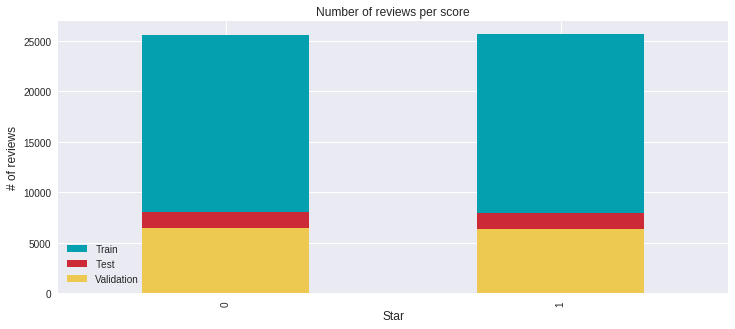

In [68]:
df_stats_train = train_df['labels'].value_counts()
df_stats_test = test_df['labels'].value_counts()
df_stats_val = val_df['labels'].value_counts()

plt.figure(figsize=(12,5))
plt.title('Number of reviews per score')
ax1 = df_stats_train.sort_index(ascending=True).plot(color='#04A0B0', grid=True, label='Train', kind='bar', legend=False)
ax2 = df_stats_test.sort_index(ascending=True).plot(color='#CC2A36', grid=True, label='Test', kind='bar', legend=False)
ax3 = df_stats_val.sort_index(ascending=True).plot(color='#EDC951', grid=True, label='Validation', kind='bar', legend=False)
ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=3)
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Star', fontsize=12)
plt.show()

**Tokenization**

In [0]:
# tokanize reviews
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
def tokenizer(s):
    return [w.text.lower() for w in nlp(s)]

**Define fields**

In [0]:
# columns to be processed
text_field = data.Field(sequential=True, 
                       tokenize=tokenizer,
                       include_lengths=True, 
                       use_vocab=True)

star_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)

df_fields = [
    ('text', text_field),
    ('labels', star_field)
]

In [0]:
# Load datasets and create torchtext dataset
trainds, valds, testds = data.TabularDataset.splits(path='./', 
                                            format='csv', 
                                            train='yelp_train.csv',
                                            validation='yelp_val.csv',
                                            test='yelp_test.csv', 
                                            fields=df_fields, 
                                            skip_header=True)

In [18]:
len(trainds), len(valds), len(testds)

(51200, 12800, 16000)

In [19]:
ex = trainds[1]
print(type(ex), '\n')
print(trainds.fields.items(), '\n')
print(ex.labels, '\n')
print(ex.text)

<class 'torchtext.data.example.Example'> 

dict_items([('text', <torchtext.data.field.Field object at 0x7f5feeb200f0>), ('labels', <torchtext.data.field.Field object at 0x7f5feeb20278>)]) 

0 

['used', 'called', 'real', 'bagel', 'done', 'fabulous', 'job', 'revamping', 'store', 'selection', 'friendly', 'service', 'unfortunate', 'fined', 'uncleanliness', 'vermin', 'city', 'montreal', 'deal', 'breaker']


## 3. Load pretrained word vectors and build vocabulary

In [20]:
# load glove embeddings
emb = vocab.Vectors('glove.6B.100d.txt', './')

100%|█████████▉| 398608/400000 [00:19<00:00, 19279.60it/s]

In [0]:
# build the vocabulary using all datasets (train, val, test) and assign the vectors
text_field.build_vocab(trainds, valds, testds, max_size=500000, vectors=emb)

In [22]:
text_field.vocab.vectors.shape

torch.Size([68666, 100])

In [25]:
text_field.vocab.vectors[text_field.vocab.stoi['best']]

tensor([ 0.1389,  0.1970,  0.6961, -0.2524,  0.2782, -0.1028,  0.2617, -0.5792,
        -0.9372,  0.0171,  0.2926, -0.6789, -0.0973, -0.2325, -0.3774,  0.1612,
         0.7874, -0.1303, -0.1270,  1.1908,  0.4064,  0.1129,  0.2895, -0.1043,
         0.5443, -0.1394, -0.0482, -0.6537,  0.1601, -0.3687, -0.5638,  0.7095,
         0.1609,  0.2768,  0.6022,  0.3836, -0.7004,  0.6079, -0.4465, -0.2227,
         0.1386,  0.4198, -0.0859, -0.1451,  0.1795,  0.1058, -0.2055, -0.9602,
        -0.1128, -0.9459, -0.3793, -0.2383,  0.0799,  1.2409, -0.1147, -2.7002,
         0.0833,  0.6994,  1.0220,  0.0415, -0.4518,  1.0464, -0.4452,  0.4341,
         1.0255, -0.5429,  0.5358,  0.5550,  0.1099, -0.1937,  0.2677,  0.3745,
        -0.1229,  0.2897,  0.2591,  0.1383, -0.6663, -0.2669, -0.0437, -0.4559,
         0.2161,  0.4007, -0.3651, -0.1738, -1.5461, -0.1422, -0.1239, -0.1028,
        -0.1560, -0.3851, -0.2516,  0.1611,  0.2244, -0.2549, -0.7697,  0.4543,
        -0.3992, -0.4139,  0.7230,  0.88

## 4. Loading the data in batches

BatchGenerator is an iterable wrapper around Batch Object that returns the desired data. 
BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. This is one of the small hiccups in torchtext, therefore BatchGenerator wrapper helps here.

In [0]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [0]:
# Create the iterator 
traindl, valdl, testdl = data.BucketIterator.splits(
                                                datasets=(trainds, valds, testds), 
                                                batch_sizes=(128,128,128), 
                                                sort_key=lambda x: len(x.text), 
                                                device=device, 
                                                sort_within_batch=True, 
                                                repeat=False,
                                                shuffle = True
                                            )

# Return text and stars and make batches iterable using the BatchGenerator wrapper
train_batches = BatchGenerator(traindl, 'text', 'labels')
val_batches = BatchGenerator(valdl, 'text', 'labels')
test_batches = BatchGenerator(testdl, 'text', 'labels')

In [28]:
len(train_batches), len(val_batches), len(test_batches)

(400, 100, 125)

## 5. Model and training

**LSTM model**

In [0]:
class RNN(nn.Module):
    def __init__(   
                    self, 
                    vocab_size, 
                    embedding_dim,
                    pretrained_embeddings,
                    num_output=2, 
                    hidden_size=32, 
                    num_layers=1
                ):

        super(RNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.pretrained_embeddings = pretrained_embeddings
        self.num_output = num_output
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer. Replace the initial weights of the embedding layer with the pre-trained embeddings
        self.encoder = nn.Embedding(self.vocab_size, self.embedding_dim, _weight=self.pretrained_embeddings)
        self.encoder.weight.requires_grad = False # the pretrained part shouldn’t be updated during training, to avoid forgetting what they already know
        
        # Dropout
        self.dropout = nn.Dropout(p = 0.5)
        
        # LSTM
        self.lstm = nn.LSTM(
                                input_size = self.embedding_dim, 
                                hidden_size = self.hidden_size, 
                                num_layers = self.num_layers
                            )
        
        # Output
        self.out = nn.Linear(self.hidden_size, self.num_output)
    
    def attention_unit(self, lstm_output, final_state):

        """ 
        Let's add Attention mechanism in the LSTM model. 
        Use attention to compute soft alignment score corresponding 
        between each of the hidden_state and the last hidden_state of the LSTM. 
        Use torch.bmm for the batch matrix multiplication.

        Arguments
        ---------

        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM

        ---------

        Returns : It performs attention mechanism by first computing weights for each of the sequence present 
        in lstm_output and then finally computing the new hidden state.

        Tensor Size :
            hidden.size() = (batch_size, hidden_size)
            attn_weights.size() = (batch_size, num_seq)
            soft_attn_weights.size() = (batch_size, num_seq)
            new_hidden_state.size() = (batch_size, hidden_size)

        """
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        
        return new_hidden_state
    
    def forward(self, x, seq_lengths):

        # x.shape => (batch_size, sequence_length)
        batch_size = x.size(1)

        # Make hidden
        hidden = self.init_hidden(batch_size)

        # Make embs ... x_embed.shape => (x, batch_size, embedding_dim)
        x_embed = self.encoder(x)
        
        # Drop some nodes
        # x_embed = self.dropout(x_embed)

        # Handling padding
        x_embed_packed = pack_padded_sequence(x_embed, seq_lengths) 
        output, (hidden_final, cell_final) = self.lstm(x_embed_packed, hidden) # hidden_final.size() = (1, batch_size, hidden_size) 
            
        # LSTM WITHOUT ATTENTION
        # No need to unpack, since we are going to use the hidden only
        # Use the last hidden layer output as fc's input
        # fc_output = self.out(hidden_final[-1])

        # LSTM WITH ATTENTION
        # We need to unpack
        output, _ = pad_packed_sequence(output, batch_first=True) # ouput.size() = (batch_size, num_seq, hidden_size)
        attn_output = self.attention_unit(output, hidden_final) 
        fc_output = self.out(attn_output)
            
        return fc_output

    def init_hidden(self, batch_size):
        
        h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
        
        return (h_0, c_0)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # convert into float for division 
    acc = correct.sum()/len(correct) 
    return acc

**Traing function**

In [0]:
# train cycle
def train(model, train_batches, criterion, optimizer):
    
    num_batch = len(train_batches)

    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    t = tqdm_notebook(iter(train_batches), leave=False, total=num_batch)
    for (input, seq_lengths), target in t:
      
        if 0 not in seq_lengths:
            # predict
            pred = model(input, seq_lengths) # returns two values per each sample 
            pred = torch.max(pred, dim=1)[0] # get the max value of two - that's the predicted label
                                                            
            # loss
            loss = criterion(pred, target.float())
            epoch_loss += loss.item()

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # binary accuracy
            acc = binary_accuracy(pred, target.float())
            epoch_acc += acc.item()
            

    train_acc =  epoch_acc/num_batch
    train_loss = epoch_loss/num_batch

    return train_loss, train_acc

In [0]:
# validation cycle
def validation(model, val_batches, criterion):
    
    num_batch = len(val_batches)
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        t = tqdm_notebook(iter(val_batches), leave=False, total=num_batch)
        for (input, seq_lengths), target in t:
            
            if 0 not in seq_lengths:
                # predict
                pred = model(input, seq_lengths) # returns two values per each sample 
                pred = torch.max(pred, dim=1)[0] # get the max value of two - that's the predicted label

                # loss and binary accuracy
                loss = criterion(pred, target.float())
                acc = binary_accuracy(pred, target.float())

                epoch_loss += loss.item()
                epoch_acc += acc.item()
                
        val_acc =  epoch_acc/num_batch
        val_loss = epoch_loss/num_batch
    
    return val_loss, val_acc

In [0]:
# test cycle
def test(model, test_batches, criterion):
    
    num_batch = len(test_batches)
    y_true_test = list()
    y_pred_test = list()

    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        t = tqdm_notebook(iter(test_batches), leave=False, total=num_batch)
        for (input, seq_lengths), target in t:  
            if 0 not in seq_lengths:
                # predict
                pred = model(input, seq_lengths) # returns two values per each sample 
                pred = torch.max(pred, dim=1)[0] # get the max value of two - that's the predicted label
                
                # loss and binary accuracy
                loss = criterion(pred, target.float())  
                acc = binary_accuracy(pred, target.float())
                
                epoch_loss += loss.item()
                epoch_acc += acc.item()
                
                # list true and predicted labels to calculate the confusion matrix and classification report
                pred_idx = torch.round(torch.sigmoid(pred)) 
                y_true_test += list(target.cpu().data.numpy())
                y_pred_test += list(pred_idx.cpu().data.numpy())
                        
        val_acc =  epoch_acc/num_batch
        val_loss = epoch_loss/num_batch
        
        cm = confusion_matrix(y_true_test, y_pred_test)
        scores = [0,1]
        sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=scores, yticklabels=scores)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
        
        print('Classification report: \n', classification_report(y_true_test, y_pred_test))

    return val_loss, val_acc

**Hyperparameters**

In [0]:
pretrained_embeddings = trainds.fields['text'].vocab.vectors
vocab_size = len(text_field.vocab)
embedding_dim = emb.dim
hidden_size = 256
num_output = 2
num_layers = 1

**Init model, optimizer and loss function**

In [0]:
model = RNN(
                    vocab_size = vocab_size, 
                    embedding_dim = embedding_dim, 
                    pretrained_embeddings = pretrained_embeddings,
                    num_output = num_output, 
                    hidden_size = hidden_size, 
                    num_layers = num_layers
                ).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.BCEWithLogitsLoss()

**Train the model**

Training for, 250  epochs...
Embeddings dim:  100
Batch size:  128
Hidden size:  256
Layers:  1 



| Epoch: 01 | Train Loss: 0.684 | Train Acc: 57.49% | Valid Loss: 0.687 | Valid Acc: 65.03%


| Epoch: 02 | Train Loss: 0.678 | Train Acc: 65.12% | Valid Loss: 0.681 | Valid Acc: 68.87%


| Epoch: 03 | Train Loss: 0.671 | Train Acc: 67.43% | Valid Loss: 0.673 | Valid Acc: 69.73%


| Epoch: 04 | Train Loss: 0.662 | Train Acc: 68.43% | Valid Loss: 0.661 | Valid Acc: 70.06%


| Epoch: 05 | Train Loss: 0.649 | Train Acc: 69.05% | Valid Loss: 0.644 | Valid Acc: 70.98%


| Epoch: 06 | Train Loss: 0.630 | Train Acc: 70.30% | Valid Loss: 0.617 | Valid Acc: 71.90%


| Epoch: 07 | Train Loss: 0.595 | Train Acc: 71.79% | Valid Loss: 0.568 | Valid Acc: 73.64%


| Epoch: 08 | Train Loss: 0.525 | Train Acc: 74.68% | Valid Loss: 0.468 | Valid Acc: 78.77%


| Epoch: 09 | Train Loss: 0.444 | Train Acc: 78.79% | Valid Loss: 0.411 | Valid Acc: 82.31%


| Epoch: 10 | Train Loss: 0.417 | Train Acc: 80.51% | Valid Loss: 0.396 | Valid Acc: 82.88%


| Epoch: 11 | Train Loss: 0.410 | Train Acc: 81.10% | Valid Loss: 0.521 | Valid Acc: 74.63%


| Epoch: 12 | Train Loss: 0.399 | Train Acc: 81.77% | Valid Loss: 0.393 | Valid Acc: 83.19%


| Epoch: 13 | Train Loss: 0.393 | Train Acc: 81.57% | Valid Loss: 0.366 | Valid Acc: 84.24%


| Epoch: 14 | Train Loss: 0.391 | Train Acc: 82.32% | Valid Loss: 0.380 | Valid Acc: 83.46%


| Epoch: 15 | Train Loss: 0.381 | Train Acc: 82.20% | Valid Loss: 0.471 | Valid Acc: 77.96%


| Epoch: 16 | Train Loss: 0.376 | Train Acc: 82.73% | Valid Loss: 0.359 | Valid Acc: 84.62%


| Epoch: 17 | Train Loss: 0.377 | Train Acc: 82.75% | Valid Loss: 0.355 | Valid Acc: 84.67%


| Epoch: 18 | Train Loss: 0.367 | Train Acc: 82.86% | Valid Loss: 0.349 | Valid Acc: 85.07%


| Epoch: 19 | Train Loss: 0.367 | Train Acc: 83.16% | Valid Loss: 0.520 | Valid Acc: 77.54%


| Epoch: 20 | Train Loss: 0.364 | Train Acc: 83.34% | Valid Loss: 0.375 | Valid Acc: 83.66%


| Epoch: 21 | Train Loss: 0.361 | Train Acc: 83.34% | Valid Loss: 0.365 | Valid Acc: 84.17%


| Epoch: 22 | Train Loss: 0.360 | Train Acc: 83.46% | Valid Loss: 0.389 | Valid Acc: 82.77%


| Epoch: 23 | Train Loss: 0.359 | Train Acc: 83.25% | Valid Loss: 0.357 | Valid Acc: 84.32%


| Epoch: 24 | Train Loss: 0.352 | Train Acc: 83.65% | Valid Loss: 0.357 | Valid Acc: 84.74%


| Epoch: 25 | Train Loss: 0.350 | Train Acc: 83.67% | Valid Loss: 0.378 | Valid Acc: 82.50%


| Epoch: 26 | Train Loss: 0.351 | Train Acc: 83.90% | Valid Loss: 0.355 | Valid Acc: 84.65%


| Epoch: 27 | Train Loss: 0.344 | Train Acc: 84.08% | Valid Loss: 0.333 | Valid Acc: 85.85%


| Epoch: 28 | Train Loss: 0.348 | Train Acc: 84.36% | Valid Loss: 0.402 | Valid Acc: 81.76%


| Epoch: 29 | Train Loss: 0.343 | Train Acc: 84.32% | Valid Loss: 0.330 | Valid Acc: 85.91%


| Epoch: 30 | Train Loss: 0.341 | Train Acc: 84.23% | Valid Loss: 0.327 | Valid Acc: 86.15%


| Epoch: 31 | Train Loss: 0.337 | Train Acc: 84.67% | Valid Loss: 0.326 | Valid Acc: 86.00%


| Epoch: 32 | Train Loss: 0.336 | Train Acc: 84.67% | Valid Loss: 0.322 | Valid Acc: 86.32%


| Epoch: 33 | Train Loss: 0.333 | Train Acc: 84.86% | Valid Loss: 0.320 | Valid Acc: 86.60%


| Epoch: 34 | Train Loss: 0.333 | Train Acc: 84.88% | Valid Loss: 0.316 | Valid Acc: 86.63%


| Epoch: 35 | Train Loss: 0.332 | Train Acc: 85.01% | Valid Loss: 0.314 | Valid Acc: 86.70%


| Epoch: 36 | Train Loss: 0.324 | Train Acc: 85.04% | Valid Loss: 0.311 | Valid Acc: 86.95%


| Epoch: 37 | Train Loss: 0.326 | Train Acc: 85.22% | Valid Loss: 0.318 | Valid Acc: 86.60%


| Epoch: 38 | Train Loss: 0.317 | Train Acc: 85.46% | Valid Loss: 0.310 | Valid Acc: 86.80%


| Epoch: 39 | Train Loss: 0.319 | Train Acc: 85.66% | Valid Loss: 0.304 | Valid Acc: 87.25%


| Epoch: 40 | Train Loss: 0.313 | Train Acc: 85.70% | Valid Loss: 0.324 | Valid Acc: 86.28%


| Epoch: 41 | Train Loss: 0.307 | Train Acc: 85.89% | Valid Loss: 0.300 | Valid Acc: 87.23%


| Epoch: 42 | Train Loss: 0.309 | Train Acc: 86.12% | Valid Loss: 0.307 | Valid Acc: 86.97%


| Epoch: 43 | Train Loss: 0.305 | Train Acc: 85.91% | Valid Loss: 0.296 | Valid Acc: 87.34%


| Epoch: 44 | Train Loss: 0.300 | Train Acc: 86.89% | Valid Loss: 0.289 | Valid Acc: 88.01%


| Epoch: 45 | Train Loss: 0.300 | Train Acc: 86.23% | Valid Loss: 0.319 | Valid Acc: 86.23%


| Epoch: 46 | Train Loss: 0.295 | Train Acc: 86.74% | Valid Loss: 0.288 | Valid Acc: 87.77%


| Epoch: 47 | Train Loss: 0.294 | Train Acc: 86.56% | Valid Loss: 0.285 | Valid Acc: 88.18%


| Epoch: 48 | Train Loss: 0.289 | Train Acc: 87.29% | Valid Loss: 0.282 | Valid Acc: 88.22%


| Epoch: 49 | Train Loss: 0.286 | Train Acc: 87.00% | Valid Loss: 0.292 | Valid Acc: 87.40%


| Epoch: 50 | Train Loss: 0.281 | Train Acc: 87.21% | Valid Loss: 0.284 | Valid Acc: 88.09%


| Epoch: 51 | Train Loss: 0.281 | Train Acc: 87.40% | Valid Loss: 0.275 | Valid Acc: 88.54%


| Epoch: 52 | Train Loss: 0.277 | Train Acc: 87.68% | Valid Loss: 0.272 | Valid Acc: 88.48%


| Epoch: 53 | Train Loss: 0.276 | Train Acc: 87.91% | Valid Loss: 0.284 | Valid Acc: 87.95%


| Epoch: 54 | Train Loss: 0.276 | Train Acc: 87.42% | Valid Loss: 0.266 | Valid Acc: 88.79%


| Epoch: 55 | Train Loss: 0.271 | Train Acc: 87.68% | Valid Loss: 0.267 | Valid Acc: 88.80%


| Epoch: 56 | Train Loss: 0.273 | Train Acc: 87.80% | Valid Loss: 0.270 | Valid Acc: 88.63%


| Epoch: 57 | Train Loss: 0.266 | Train Acc: 88.16% | Valid Loss: 0.288 | Valid Acc: 87.75%


| Epoch: 58 | Train Loss: 0.267 | Train Acc: 88.15% | Valid Loss: 0.268 | Valid Acc: 88.89%


| Epoch: 59 | Train Loss: 0.263 | Train Acc: 88.24% | Valid Loss: 0.259 | Valid Acc: 89.18%


| Epoch: 60 | Train Loss: 0.264 | Train Acc: 88.13% | Valid Loss: 0.258 | Valid Acc: 89.09%


| Epoch: 61 | Train Loss: 0.259 | Train Acc: 88.13% | Valid Loss: 0.257 | Valid Acc: 89.32%


| Epoch: 62 | Train Loss: 0.266 | Train Acc: 87.99% | Valid Loss: 0.255 | Valid Acc: 89.25%


| Epoch: 63 | Train Loss: 0.257 | Train Acc: 88.49% | Valid Loss: 0.254 | Valid Acc: 89.34%


| Epoch: 64 | Train Loss: 0.255 | Train Acc: 88.73% | Valid Loss: 0.256 | Valid Acc: 89.31%


| Epoch: 65 | Train Loss: 0.254 | Train Acc: 88.39% | Valid Loss: 0.253 | Valid Acc: 89.51%


| Epoch: 66 | Train Loss: 0.252 | Train Acc: 88.52% | Valid Loss: 0.269 | Valid Acc: 88.84%


| Epoch: 67 | Train Loss: 0.252 | Train Acc: 88.70% | Valid Loss: 0.252 | Valid Acc: 89.50%


| Epoch: 68 | Train Loss: 0.252 | Train Acc: 88.84% | Valid Loss: 0.250 | Valid Acc: 89.66%


| Epoch: 69 | Train Loss: 0.246 | Train Acc: 88.71% | Valid Loss: 0.251 | Valid Acc: 89.57%


| Epoch: 70 | Train Loss: 0.250 | Train Acc: 88.56% | Valid Loss: 0.249 | Valid Acc: 89.62%


| Epoch: 71 | Train Loss: 0.247 | Train Acc: 88.72% | Valid Loss: 0.248 | Valid Acc: 89.66%


| Epoch: 72 | Train Loss: 0.249 | Train Acc: 88.87% | Valid Loss: 0.246 | Valid Acc: 89.94%


| Epoch: 73 | Train Loss: 0.244 | Train Acc: 88.81% | Valid Loss: 0.243 | Valid Acc: 89.91%


| Epoch: 74 | Train Loss: 0.240 | Train Acc: 89.00% | Valid Loss: 0.244 | Valid Acc: 89.84%


| Epoch: 75 | Train Loss: 0.242 | Train Acc: 89.44% | Valid Loss: 0.244 | Valid Acc: 89.95%


| Epoch: 76 | Train Loss: 0.242 | Train Acc: 88.92% | Valid Loss: 0.242 | Valid Acc: 90.05%


| Epoch: 77 | Train Loss: 0.238 | Train Acc: 89.37% | Valid Loss: 0.267 | Valid Acc: 89.17%


| Epoch: 78 | Train Loss: 0.239 | Train Acc: 89.18% | Valid Loss: 0.244 | Valid Acc: 89.99%


| Epoch: 79 | Train Loss: 0.240 | Train Acc: 88.97% | Valid Loss: 0.241 | Valid Acc: 89.99%


| Epoch: 80 | Train Loss: 0.238 | Train Acc: 89.31% | Valid Loss: 0.241 | Valid Acc: 90.05%


| Epoch: 81 | Train Loss: 0.236 | Train Acc: 89.22% | Valid Loss: 0.242 | Valid Acc: 90.12%


| Epoch: 82 | Train Loss: 0.234 | Train Acc: 89.55% | Valid Loss: 0.252 | Valid Acc: 89.67%


| Epoch: 83 | Train Loss: 0.235 | Train Acc: 89.51% | Valid Loss: 0.239 | Valid Acc: 90.20%


| Epoch: 84 | Train Loss: 0.232 | Train Acc: 89.27% | Valid Loss: 0.238 | Valid Acc: 90.15%


| Epoch: 85 | Train Loss: 0.233 | Train Acc: 89.64% | Valid Loss: 0.242 | Valid Acc: 90.11%


| Epoch: 86 | Train Loss: 0.230 | Train Acc: 89.75% | Valid Loss: 0.242 | Valid Acc: 90.23%


| Epoch: 87 | Train Loss: 0.233 | Train Acc: 89.52% | Valid Loss: 0.236 | Valid Acc: 90.34%


| Epoch: 88 | Train Loss: 0.230 | Train Acc: 89.73% | Valid Loss: 0.240 | Valid Acc: 90.12%


| Epoch: 89 | Train Loss: 0.228 | Train Acc: 89.61% | Valid Loss: 0.237 | Valid Acc: 90.31%


| Epoch: 90 | Train Loss: 0.230 | Train Acc: 89.68% | Valid Loss: 0.232 | Valid Acc: 90.40%


| Epoch: 91 | Train Loss: 0.230 | Train Acc: 89.66% | Valid Loss: 0.232 | Valid Acc: 90.44%


| Epoch: 92 | Train Loss: 0.225 | Train Acc: 89.67% | Valid Loss: 0.232 | Valid Acc: 90.42%


| Epoch: 93 | Train Loss: 0.227 | Train Acc: 89.69% | Valid Loss: 0.232 | Valid Acc: 90.48%


| Epoch: 94 | Train Loss: 0.229 | Train Acc: 89.47% | Valid Loss: 0.233 | Valid Acc: 90.41%


| Epoch: 95 | Train Loss: 0.226 | Train Acc: 89.58% | Valid Loss: 0.230 | Valid Acc: 90.44%


| Epoch: 96 | Train Loss: 0.224 | Train Acc: 89.98% | Valid Loss: 0.230 | Valid Acc: 90.52%


| Epoch: 97 | Train Loss: 0.224 | Train Acc: 89.69% | Valid Loss: 0.245 | Valid Acc: 90.03%


| Epoch: 98 | Train Loss: 0.223 | Train Acc: 89.73% | Valid Loss: 0.230 | Valid Acc: 90.52%


| Epoch: 99 | Train Loss: 0.226 | Train Acc: 90.14% | Valid Loss: 0.230 | Valid Acc: 90.50%


| Epoch: 100 | Train Loss: 0.220 | Train Acc: 90.07% | Valid Loss: 0.233 | Valid Acc: 90.40%


| Epoch: 101 | Train Loss: 0.219 | Train Acc: 89.99% | Valid Loss: 0.232 | Valid Acc: 90.46%


| Epoch: 102 | Train Loss: 0.222 | Train Acc: 89.80% | Valid Loss: 0.323 | Valid Acc: 86.20%


| Epoch: 103 | Train Loss: 0.222 | Train Acc: 90.67% | Valid Loss: 0.229 | Valid Acc: 90.58%


| Epoch: 104 | Train Loss: 0.220 | Train Acc: 90.11% | Valid Loss: 0.226 | Valid Acc: 90.70%


| Epoch: 105 | Train Loss: 0.219 | Train Acc: 89.91% | Valid Loss: 0.229 | Valid Acc: 90.60%


| Epoch: 106 | Train Loss: 0.217 | Train Acc: 90.03% | Valid Loss: 0.232 | Valid Acc: 90.52%


| Epoch: 107 | Train Loss: 0.217 | Train Acc: 90.04% | Valid Loss: 0.236 | Valid Acc: 90.28%


| Epoch: 108 | Train Loss: 0.218 | Train Acc: 89.96% | Valid Loss: 0.228 | Valid Acc: 90.60%


| Epoch: 109 | Train Loss: 0.216 | Train Acc: 90.10% | Valid Loss: 0.225 | Valid Acc: 90.70%


| Epoch: 110 | Train Loss: 0.218 | Train Acc: 90.31% | Valid Loss: 0.224 | Valid Acc: 90.86%


| Epoch: 111 | Train Loss: 0.216 | Train Acc: 90.33% | Valid Loss: 0.235 | Valid Acc: 90.34%


| Epoch: 112 | Train Loss: 0.215 | Train Acc: 90.04% | Valid Loss: 0.229 | Valid Acc: 90.69%


| Epoch: 113 | Train Loss: 0.216 | Train Acc: 90.06% | Valid Loss: 0.222 | Valid Acc: 90.73%


| Epoch: 114 | Train Loss: 0.216 | Train Acc: 90.31% | Valid Loss: 0.227 | Valid Acc: 90.68%


| Epoch: 115 | Train Loss: 0.214 | Train Acc: 90.09% | Valid Loss: 0.222 | Valid Acc: 90.91%


| Epoch: 116 | Train Loss: 0.212 | Train Acc: 90.22% | Valid Loss: 0.222 | Valid Acc: 91.01%


| Epoch: 117 | Train Loss: 0.212 | Train Acc: 90.19% | Valid Loss: 0.221 | Valid Acc: 90.85%


| Epoch: 118 | Train Loss: 0.214 | Train Acc: 90.40% | Valid Loss: 0.222 | Valid Acc: 90.85%


| Epoch: 119 | Train Loss: 0.212 | Train Acc: 90.43% | Valid Loss: 0.220 | Valid Acc: 90.86%


| Epoch: 120 | Train Loss: 0.210 | Train Acc: 90.36% | Valid Loss: 0.221 | Valid Acc: 90.94%


| Epoch: 121 | Train Loss: 0.214 | Train Acc: 90.70% | Valid Loss: 0.247 | Valid Acc: 89.98%


| Epoch: 122 | Train Loss: 0.211 | Train Acc: 90.24% | Valid Loss: 0.221 | Valid Acc: 90.83%


| Epoch: 123 | Train Loss: 0.209 | Train Acc: 90.30% | Valid Loss: 0.224 | Valid Acc: 90.85%


| Epoch: 124 | Train Loss: 0.212 | Train Acc: 90.62% | Valid Loss: 0.265 | Valid Acc: 89.09%


| Epoch: 125 | Train Loss: 0.211 | Train Acc: 90.50% | Valid Loss: 0.234 | Valid Acc: 90.42%


| Epoch: 126 | Train Loss: 0.210 | Train Acc: 90.76% | Valid Loss: 0.220 | Valid Acc: 90.94%


| Epoch: 127 | Train Loss: 0.208 | Train Acc: 90.72% | Valid Loss: 0.225 | Valid Acc: 90.73%


| Epoch: 128 | Train Loss: 0.208 | Train Acc: 90.38% | Valid Loss: 0.222 | Valid Acc: 90.94%


| Epoch: 129 | Train Loss: 0.211 | Train Acc: 90.66% | Valid Loss: 0.219 | Valid Acc: 91.05%


| Epoch: 130 | Train Loss: 0.209 | Train Acc: 90.60% | Valid Loss: 0.218 | Valid Acc: 91.06%


| Epoch: 131 | Train Loss: 0.207 | Train Acc: 90.68% | Valid Loss: 0.221 | Valid Acc: 90.92%


| Epoch: 132 | Train Loss: 0.206 | Train Acc: 90.54% | Valid Loss: 0.217 | Valid Acc: 90.92%


| Epoch: 133 | Train Loss: 0.207 | Train Acc: 90.44% | Valid Loss: 0.225 | Valid Acc: 90.80%


| Epoch: 134 | Train Loss: 0.205 | Train Acc: 90.81% | Valid Loss: 0.217 | Valid Acc: 91.06%


| Epoch: 135 | Train Loss: 0.203 | Train Acc: 90.63% | Valid Loss: 0.227 | Valid Acc: 90.66%


| Epoch: 136 | Train Loss: 0.205 | Train Acc: 90.81% | Valid Loss: 0.286 | Valid Acc: 88.11%


| Epoch: 137 | Train Loss: 0.207 | Train Acc: 90.73% | Valid Loss: 0.219 | Valid Acc: 91.11%


| Epoch: 138 | Train Loss: 0.205 | Train Acc: 90.63% | Valid Loss: 0.216 | Valid Acc: 91.11%


| Epoch: 139 | Train Loss: 0.207 | Train Acc: 90.90% | Valid Loss: 0.216 | Valid Acc: 91.12%


| Epoch: 140 | Train Loss: 0.204 | Train Acc: 90.81% | Valid Loss: 0.232 | Valid Acc: 90.38%


| Epoch: 141 | Train Loss: 0.203 | Train Acc: 90.61% | Valid Loss: 0.215 | Valid Acc: 91.09%


| Epoch: 142 | Train Loss: 0.203 | Train Acc: 90.64% | Valid Loss: 0.216 | Valid Acc: 91.02%


| Epoch: 143 | Train Loss: 0.202 | Train Acc: 91.03% | Valid Loss: 0.231 | Valid Acc: 90.43%


| Epoch: 144 | Train Loss: 0.202 | Train Acc: 90.71% | Valid Loss: 0.231 | Valid Acc: 90.28%


| Epoch: 145 | Train Loss: 0.202 | Train Acc: 90.88% | Valid Loss: 0.214 | Valid Acc: 91.11%


| Epoch: 146 | Train Loss: 0.200 | Train Acc: 91.03% | Valid Loss: 0.217 | Valid Acc: 91.01%


| Epoch: 147 | Train Loss: 0.201 | Train Acc: 90.90% | Valid Loss: 0.214 | Valid Acc: 91.12%


| Epoch: 148 | Train Loss: 0.199 | Train Acc: 90.80% | Valid Loss: 0.219 | Valid Acc: 91.04%


| Epoch: 149 | Train Loss: 0.200 | Train Acc: 90.78% | Valid Loss: 0.217 | Valid Acc: 90.98%


| Epoch: 150 | Train Loss: 0.203 | Train Acc: 90.94% | Valid Loss: 0.257 | Valid Acc: 89.56%


| Epoch: 151 | Train Loss: 0.201 | Train Acc: 91.02% | Valid Loss: 0.217 | Valid Acc: 91.14%


| Epoch: 152 | Train Loss: 0.199 | Train Acc: 91.21% | Valid Loss: 0.227 | Valid Acc: 90.80%


| Epoch: 153 | Train Loss: 0.201 | Train Acc: 91.10% | Valid Loss: 0.217 | Valid Acc: 90.94%


| Epoch: 154 | Train Loss: 0.197 | Train Acc: 90.85% | Valid Loss: 0.217 | Valid Acc: 91.14%


| Epoch: 155 | Train Loss: 0.198 | Train Acc: 91.15% | Valid Loss: 0.218 | Valid Acc: 91.03%


| Epoch: 156 | Train Loss: 0.196 | Train Acc: 91.02% | Valid Loss: 0.213 | Valid Acc: 91.33%


| Epoch: 157 | Train Loss: 0.195 | Train Acc: 90.96% | Valid Loss: 0.216 | Valid Acc: 91.08%


| Epoch: 158 | Train Loss: 0.197 | Train Acc: 91.13% | Valid Loss: 0.213 | Valid Acc: 91.22%


| Epoch: 159 | Train Loss: 0.197 | Train Acc: 90.91% | Valid Loss: 0.217 | Valid Acc: 91.09%


| Epoch: 160 | Train Loss: 0.196 | Train Acc: 91.15% | Valid Loss: 0.211 | Valid Acc: 91.36%


| Epoch: 161 | Train Loss: 0.195 | Train Acc: 91.15% | Valid Loss: 0.211 | Valid Acc: 91.24%


| Epoch: 162 | Train Loss: 0.195 | Train Acc: 91.21% | Valid Loss: 0.212 | Valid Acc: 91.20%


| Epoch: 163 | Train Loss: 0.196 | Train Acc: 91.18% | Valid Loss: 0.213 | Valid Acc: 91.23%


| Epoch: 164 | Train Loss: 0.196 | Train Acc: 91.51% | Valid Loss: 0.213 | Valid Acc: 91.38%


| Epoch: 165 | Train Loss: 0.193 | Train Acc: 91.27% | Valid Loss: 0.219 | Valid Acc: 90.93%


| Epoch: 166 | Train Loss: 0.193 | Train Acc: 91.25% | Valid Loss: 0.214 | Valid Acc: 91.14%


| Epoch: 167 | Train Loss: 0.196 | Train Acc: 90.88% | Valid Loss: 0.211 | Valid Acc: 91.30%


| Epoch: 168 | Train Loss: 0.195 | Train Acc: 91.28% | Valid Loss: 0.212 | Valid Acc: 91.20%


| Epoch: 169 | Train Loss: 0.194 | Train Acc: 91.03% | Valid Loss: 0.210 | Valid Acc: 91.28%


| Epoch: 170 | Train Loss: 0.193 | Train Acc: 90.99% | Valid Loss: 0.222 | Valid Acc: 90.88%


| Epoch: 171 | Train Loss: 0.194 | Train Acc: 91.22% | Valid Loss: 0.223 | Valid Acc: 90.83%


| Epoch: 172 | Train Loss: 0.192 | Train Acc: 91.11% | Valid Loss: 0.221 | Valid Acc: 91.08%


| Epoch: 173 | Train Loss: 0.190 | Train Acc: 91.41% | Valid Loss: 0.211 | Valid Acc: 91.48%


| Epoch: 174 | Train Loss: 0.192 | Train Acc: 91.27% | Valid Loss: 0.210 | Valid Acc: 91.28%


| Epoch: 175 | Train Loss: 0.193 | Train Acc: 91.27% | Valid Loss: 0.223 | Valid Acc: 90.95%


| Epoch: 176 | Train Loss: 0.191 | Train Acc: 91.17% | Valid Loss: 0.211 | Valid Acc: 91.20%


| Epoch: 177 | Train Loss: 0.191 | Train Acc: 91.45% | Valid Loss: 0.218 | Valid Acc: 90.90%


| Epoch: 178 | Train Loss: 0.190 | Train Acc: 91.44% | Valid Loss: 0.210 | Valid Acc: 91.34%


| Epoch: 179 | Train Loss: 0.190 | Train Acc: 91.23% | Valid Loss: 0.211 | Valid Acc: 91.38%


| Epoch: 180 | Train Loss: 0.191 | Train Acc: 91.45% | Valid Loss: 0.219 | Valid Acc: 90.99%


| Epoch: 181 | Train Loss: 0.191 | Train Acc: 91.37% | Valid Loss: 0.211 | Valid Acc: 91.27%


| Epoch: 182 | Train Loss: 0.191 | Train Acc: 91.45% | Valid Loss: 0.211 | Valid Acc: 91.41%


| Epoch: 183 | Train Loss: 0.188 | Train Acc: 91.28% | Valid Loss: 0.209 | Valid Acc: 91.42%


| Epoch: 184 | Train Loss: 0.187 | Train Acc: 91.29% | Valid Loss: 0.209 | Valid Acc: 91.34%


| Epoch: 185 | Train Loss: 0.189 | Train Acc: 91.29% | Valid Loss: 0.209 | Valid Acc: 91.47%


| Epoch: 186 | Train Loss: 0.187 | Train Acc: 91.61% | Valid Loss: 0.366 | Valid Acc: 84.88%


| Epoch: 187 | Train Loss: 0.187 | Train Acc: 91.44% | Valid Loss: 0.209 | Valid Acc: 91.41%


| Epoch: 188 | Train Loss: 0.187 | Train Acc: 91.30% | Valid Loss: 0.226 | Valid Acc: 90.73%


| Epoch: 189 | Train Loss: 0.188 | Train Acc: 91.50% | Valid Loss: 0.233 | Valid Acc: 90.50%


| Epoch: 190 | Train Loss: 0.185 | Train Acc: 91.41% | Valid Loss: 0.210 | Valid Acc: 91.48%


| Epoch: 191 | Train Loss: 0.186 | Train Acc: 91.36% | Valid Loss: 0.221 | Valid Acc: 90.88%


| Epoch: 192 | Train Loss: 0.185 | Train Acc: 91.39% | Valid Loss: 0.228 | Valid Acc: 90.62%


| Epoch: 193 | Train Loss: 0.186 | Train Acc: 91.40% | Valid Loss: 0.210 | Valid Acc: 91.52%


| Epoch: 194 | Train Loss: 0.184 | Train Acc: 91.54% | Valid Loss: 0.237 | Valid Acc: 90.32%


| Epoch: 195 | Train Loss: 0.184 | Train Acc: 91.46% | Valid Loss: 0.211 | Valid Acc: 91.35%


| Epoch: 196 | Train Loss: 0.186 | Train Acc: 91.37% | Valid Loss: 0.210 | Valid Acc: 91.30%


| Epoch: 197 | Train Loss: 0.183 | Train Acc: 91.79% | Valid Loss: 0.210 | Valid Acc: 91.51%


| Epoch: 198 | Train Loss: 0.184 | Train Acc: 91.73% | Valid Loss: 0.210 | Valid Acc: 91.48%


| Epoch: 199 | Train Loss: 0.185 | Train Acc: 91.71% | Valid Loss: 0.207 | Valid Acc: 91.56%


| Epoch: 200 | Train Loss: 0.184 | Train Acc: 91.50% | Valid Loss: 0.208 | Valid Acc: 91.62%


| Epoch: 201 | Train Loss: 0.185 | Train Acc: 91.66% | Valid Loss: 0.211 | Valid Acc: 91.40%


| Epoch: 202 | Train Loss: 0.182 | Train Acc: 91.55% | Valid Loss: 0.210 | Valid Acc: 91.50%


| Epoch: 203 | Train Loss: 0.182 | Train Acc: 91.64% | Valid Loss: 0.207 | Valid Acc: 91.61%


| Epoch: 204 | Train Loss: 0.183 | Train Acc: 91.47% | Valid Loss: 0.209 | Valid Acc: 91.45%


| Epoch: 205 | Train Loss: 0.181 | Train Acc: 91.82% | Valid Loss: 0.210 | Valid Acc: 91.44%


| Epoch: 206 | Train Loss: 0.183 | Train Acc: 91.79% | Valid Loss: 0.207 | Valid Acc: 91.56%


| Epoch: 207 | Train Loss: 0.182 | Train Acc: 91.49% | Valid Loss: 0.215 | Valid Acc: 91.21%


| Epoch: 208 | Train Loss: 0.182 | Train Acc: 91.86% | Valid Loss: 0.229 | Valid Acc: 90.64%


| Epoch: 209 | Train Loss: 0.181 | Train Acc: 91.83% | Valid Loss: 0.209 | Valid Acc: 91.54%


| Epoch: 210 | Train Loss: 0.180 | Train Acc: 91.72% | Valid Loss: 0.210 | Valid Acc: 91.48%


| Epoch: 211 | Train Loss: 0.181 | Train Acc: 91.55% | Valid Loss: 0.215 | Valid Acc: 91.30%


| Epoch: 212 | Train Loss: 0.181 | Train Acc: 91.82% | Valid Loss: 0.207 | Valid Acc: 91.58%


| Epoch: 213 | Train Loss: 0.181 | Train Acc: 91.87% | Valid Loss: 0.206 | Valid Acc: 91.68%


| Epoch: 214 | Train Loss: 0.179 | Train Acc: 91.93% | Valid Loss: 0.206 | Valid Acc: 91.67%


| Epoch: 215 | Train Loss: 0.177 | Train Acc: 91.79% | Valid Loss: 0.248 | Valid Acc: 89.99%


| Epoch: 216 | Train Loss: 0.177 | Train Acc: 91.80% | Valid Loss: 0.257 | Valid Acc: 89.67%


| Epoch: 217 | Train Loss: 0.177 | Train Acc: 91.78% | Valid Loss: 0.207 | Valid Acc: 91.53%


| Epoch: 218 | Train Loss: 0.177 | Train Acc: 92.23% | Valid Loss: 0.207 | Valid Acc: 91.59%


| Epoch: 219 | Train Loss: 0.178 | Train Acc: 91.77% | Valid Loss: 0.209 | Valid Acc: 91.45%


| Epoch: 220 | Train Loss: 0.177 | Train Acc: 91.75% | Valid Loss: 0.212 | Valid Acc: 91.47%


| Epoch: 221 | Train Loss: 0.177 | Train Acc: 91.79% | Valid Loss: 0.207 | Valid Acc: 91.59%


| Epoch: 222 | Train Loss: 0.177 | Train Acc: 92.03% | Valid Loss: 0.209 | Valid Acc: 91.41%


| Epoch: 223 | Train Loss: 0.175 | Train Acc: 91.85% | Valid Loss: 0.207 | Valid Acc: 91.59%


| Epoch: 224 | Train Loss: 0.177 | Train Acc: 91.82% | Valid Loss: 0.216 | Valid Acc: 91.21%


| Epoch: 225 | Train Loss: 0.176 | Train Acc: 91.81% | Valid Loss: 0.208 | Valid Acc: 91.54%


| Epoch: 226 | Train Loss: 0.177 | Train Acc: 92.00% | Valid Loss: 0.206 | Valid Acc: 91.72%


| Epoch: 227 | Train Loss: 0.175 | Train Acc: 92.21% | Valid Loss: 0.212 | Valid Acc: 91.29%


| Epoch: 228 | Train Loss: 0.176 | Train Acc: 92.11% | Valid Loss: 0.205 | Valid Acc: 91.70%


| Epoch: 229 | Train Loss: 0.176 | Train Acc: 92.10% | Valid Loss: 0.205 | Valid Acc: 91.68%


| Epoch: 230 | Train Loss: 0.173 | Train Acc: 92.23% | Valid Loss: 0.208 | Valid Acc: 91.74%


| Epoch: 231 | Train Loss: 0.174 | Train Acc: 92.14% | Valid Loss: 0.205 | Valid Acc: 91.69%


| Epoch: 232 | Train Loss: 0.174 | Train Acc: 91.95% | Valid Loss: 0.211 | Valid Acc: 91.59%


| Epoch: 233 | Train Loss: 0.175 | Train Acc: 91.89% | Valid Loss: 0.207 | Valid Acc: 91.46%


| Epoch: 234 | Train Loss: 0.176 | Train Acc: 92.11% | Valid Loss: 0.207 | Valid Acc: 91.66%


| Epoch: 235 | Train Loss: 0.172 | Train Acc: 92.23% | Valid Loss: 0.208 | Valid Acc: 91.72%


| Epoch: 236 | Train Loss: 0.172 | Train Acc: 92.01% | Valid Loss: 0.206 | Valid Acc: 91.52%


| Epoch: 237 | Train Loss: 0.176 | Train Acc: 92.10% | Valid Loss: 0.209 | Valid Acc: 91.55%


| Epoch: 238 | Train Loss: 0.174 | Train Acc: 92.15% | Valid Loss: 0.214 | Valid Acc: 91.39%


| Epoch: 239 | Train Loss: 0.173 | Train Acc: 91.95% | Valid Loss: 0.210 | Valid Acc: 91.65%


| Epoch: 240 | Train Loss: 0.174 | Train Acc: 91.94% | Valid Loss: 0.219 | Valid Acc: 91.20%


| Epoch: 241 | Train Loss: 0.173 | Train Acc: 92.22% | Valid Loss: 0.210 | Valid Acc: 91.48%


| Epoch: 242 | Train Loss: 0.174 | Train Acc: 92.13% | Valid Loss: 0.207 | Valid Acc: 91.64%


| Epoch: 243 | Train Loss: 0.170 | Train Acc: 92.05% | Valid Loss: 0.215 | Valid Acc: 91.29%


| Epoch: 244 | Train Loss: 0.170 | Train Acc: 92.14% | Valid Loss: 0.204 | Valid Acc: 91.65%


| Epoch: 245 | Train Loss: 0.169 | Train Acc: 92.16% | Valid Loss: 0.214 | Valid Acc: 91.38%


| Epoch: 246 | Train Loss: 0.171 | Train Acc: 92.33% | Valid Loss: 0.205 | Valid Acc: 91.66%


| Epoch: 247 | Train Loss: 0.170 | Train Acc: 92.40% | Valid Loss: 0.213 | Valid Acc: 91.57%


| Epoch: 248 | Train Loss: 0.169 | Train Acc: 92.24% | Valid Loss: 0.207 | Valid Acc: 91.67%


| Epoch: 249 | Train Loss: 0.168 | Train Acc: 92.19% | Valid Loss: 0.209 | Valid Acc: 91.56%


| Epoch: 250 | Train Loss: 0.169 | Train Acc: 92.13% | Valid Loss: 0.207 | Valid Acc: 91.62%


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


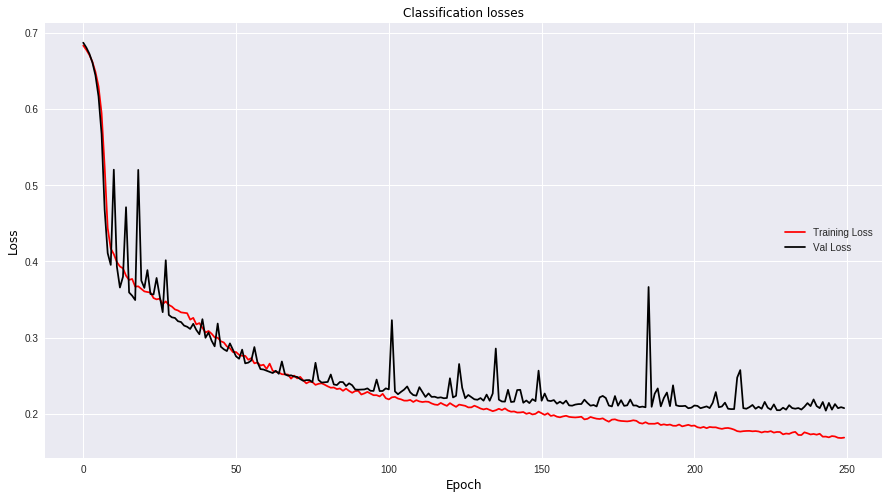

In [82]:
epochs = 250
train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

print("Training for," , epochs , " epochs...")
print("Embeddings dim: ", embedding_dim)
print("Batch size: ", train_batches.dl.batch_size)
print("Hidden size: ", hidden_size)
print("Layers: ", num_layers, "\n")

for epoch in range(1, epochs + 1):
    
    # Training
    train_loss, train_acc = train(model, train_batches, criterion, optimizer)
    
    # Validation
    val_loss, val_acc = validation(model, val_batches, criterion)
    
    # Append losses per epoch for plotting
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    # Append accuracies per epoch for plotting
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
    print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}%')

    
# Plot the losses and accuracies
fig = plt.figure(figsize=(15,8))
font = {'family' : 'Arial', 'color'  : 'black', 'weight' : 'normal', 'size'   : 12,}

ax1 = fig.add_subplot(111)
ln1 = ax1.plot(train_loss_history, 'r', label='Training Loss')
ln2 = ax1.plot(val_loss_history, 'k', label='Val Loss')

lns = ln1+ ln2
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, loc=7)
ax1.set_ylabel('Loss', fontdict=font)
ax1.set_title("Classification losses", fontdict=font)
ax1.set_xlabel('Epoch', fontdict=font)

plt.show()

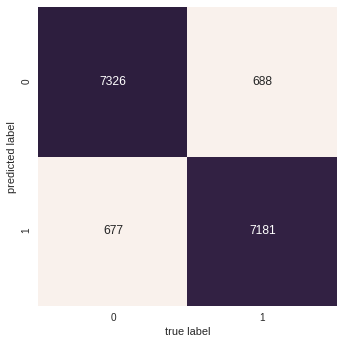

Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      8003
           1       0.91      0.91      0.91      7869

   micro avg       0.91      0.91      0.91     15872
   macro avg       0.91      0.91      0.91     15872
weighted avg       0.91      0.91      0.91     15872

| Test Loss: 0.213 | Test Acc: 90.67% |


In [83]:
# 250 epochs
test_loss, test_acc = test(model, test_batches, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')